In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"
import findspark
findspark.init()

spark-3.0.1-bin-hadoop2.7/
spark-3.0.1-bin-hadoop2.7/RELEASE
spark-3.0.1-bin-hadoop2.7/examples/
spark-3.0.1-bin-hadoop2.7/examples/src/
spark-3.0.1-bin-hadoop2.7/examples/src/main/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/FPGrowthExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/GBTExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/ALSExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/KMeansExample.scala
spark-3.0.1-bin-hadoop2.7/example

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [3]:
ReadCamTrans = spark.read.option("inferSchema","true").csv("Data/Query + Visualization/camera_transactions.csv",header=True)
ReadCam = spark.read.option("inferSchema","true").csv("Data/Query + Visualization/cameras.csv",header=True)
ReadLensTrans = spark.read.option("inferSchema","true").csv("Data/Query + Visualization/lens_transactions.csv",header=True)
ReadLens = spark.read.option("inferSchema","true").csv("Data/Query + Visualization/lenses.csv",header=True)
ReadMembers = spark.read.option("inferSchema","true").csv("Data/Query + Visualization/members.csv",header=True)
ReadStaffs = spark.read.option("inferSchema","true").csv("Data/Query + Visualization/staffs.csv",header=True)
ReadTransHeaders = spark.read.option("inferSchema","true").csv("Data/Query + Visualization/transaction_headers.csv",header=True)

In [4]:
ReadCamTrans.registerTempTable("camera_transactions")
ReadCam.registerTempTable("cameras")
ReadLensTrans.registerTempTable("lens_transaction")
ReadLens.registerTempTable("lenses")
ReadMembers.registerTempTable("members")
ReadStaffs.registerTempTable("staffs")
ReadTransHeaders.registerTempTable("transaction_header")

+-------------+---------+
|member_gender|lensgross|
+-------------+---------+
|       Female|    86956|
|         Male|   203460|
+-------------+---------+



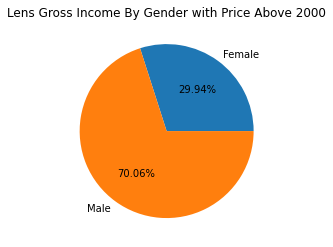

In [5]:
import matplotlib.pyplot as plt

Lingkaran = spark.sql("""SELECT member_gender, SUM(lens_price*quantity) as lensgross
                    FROM lenses L
                    JOIN lens_transaction LT ON L.lens_id = LT.lens_id
                    JOIN transaction_header TH ON TH.transaction_id = LT.transaction_id
                    JOIN members M ON M.member_id = TH.member_id 
                    WHERE lens_price >2000
                    GROUP BY member_gender""")
Lingkaran.show()
Lingkaran = Lingkaran.toPandas()
plt.title("Lens Gross Income By Gender with Price Above 2000")
plt.pie(Lingkaran['lensgross'],labels=Lingkaran['member_gender'],autopct="%.2f%%")
plt.show()

+-------------+-----+
|MonthlyProfit|Month|
+-------------+-----+
|        49450|    3|
|       241089|    4|
|        50152|    5|
|       134412|    6|
|       192658|    7|
|       184772|    8|
|        62813|    9|
|       230741|   10|
+-------------+-----+



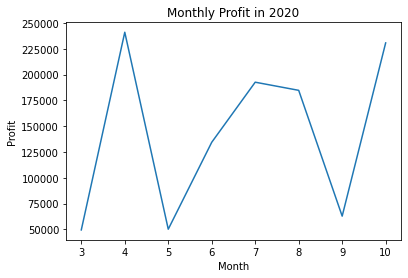

In [9]:
HasilB = spark.sql("""SELECT SUM((lens_price * LT.quantity) + (camera_price * CT.quantity)) AS MonthlyProfit,MONTH(transaction_date_time) AS Month
                      FROM lenses L
                      JOIN lens_transaction LT ON L.lens_id = LT.lens_id
                      JOIN transaction_header TH ON LT.transaction_id = TH.transaction_id
                      JOIN camera_transactions CT ON TH.transaction_id = CT.transaction_id
                      JOIN cameras C ON C.camera_id = CT.camera_id
                      GROUP BY Month
                      ORDER BY Month""")

HasilB.show()
HasilB = HasilB.toPandas()
plt.plot(HasilB['MonthlyProfit'])
plt.xticks(range(len(HasilB['Month'])),HasilB['Month'])
plt.xlabel("Month")
plt.ylabel("Profit")
plt.title("Monthly Profit in 2020")
plt.show()

+---------+--------------+
|Frequency|    Profitable|
+---------+--------------+
|        4|    Profitable|
|       18|Non Profitable|
+---------+--------------+



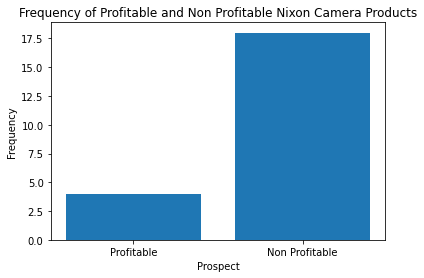

In [8]:
resC = spark.sql("""SELECT COUNT(x.camera_id) AS Frequency,x.Profitable FROM (
                    SELECT a.camera_id,
                    CASE
                        WHEN SUM(a.camera_price*b.quantity) >10000 THEN 'Profitable'
                        ELSE 'Non Profitable'
                    END AS Profitable
                    FROM cameras a
                    LEFT JOIN camera_transactions b on a.camera_id=b.camera_id
                    WHERE a.camera_manufacturer = 'Nikon'
                    GROUP BY a.camera_id
                ) as x
                GROUP BY x.Profitable""")
resC.show()
resC=resC.toPandas()
plt.bar(resC['Profitable'],resC['Frequency'])
plt.xlabel('Prospect')
plt.ylabel('Frequency')
plt.title("Frequency of Profitable and Non Profitable Nixon Camera Products")
plt.show()